In [2]:
import numpy as np
import pandas as pd 
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import backend as K
import time

In [3]:
base_dir ='/kaggle/input/mura-v11/MURA-v1.1'

def load_data():
    image_paths = []
    labels = []

    for folder in ['train', 'valid']:
        folder_path = os.path.join(base_dir, folder, 'XR_FINGER')
        for patient_folder in os.listdir(folder_path):
            for study_folder in os.listdir(os.path.join(folder_path, patient_folder)):
                folder_name = study_folder.lower() 
                if 'positive' in folder_name:
                    label = 'positive' 
                elif 'negative' in folder_name:
                    label = 'negative'
                else:
                    continue 

                for image_file in os.listdir(os.path.join(folder_path, patient_folder, study_folder)):
                    image_path = os.path.join(folder_path, patient_folder, study_folder, image_file)
                    image_paths.append(image_path)
                    labels.append(label)

    return image_paths, labels

In [4]:
image_paths, labels = load_data()

In [5]:
indices = np.arange(len(image_paths))


shuffled_image_paths = []
shuffled_labels = []

for index in indices:
    image_path = image_paths[index]
    label = labels[index]

    image = Image.open(image_path)
    image = image.resize((224, 224), Image.BILINEAR)
    image=image.convert('RGB')

    image_array = np.array(image)

    shuffled_image_paths.append(image_array)
    shuffled_labels.append(label)

X_shuffled = np.array(shuffled_image_paths)
Y_shuffled = np.array(shuffled_labels)

In [6]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X_shuffled, Y_shuffled, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [7]:
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_val_encoded = label_encoder.transform(Y_val)
Y_test_encoded = label_encoder.transform(Y_test)

In [8]:
image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [9]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        
        
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')  
        self.start_time= time.time() # set the time at which training started
        
    def on_train_end(self, logs=None):   # runs at the end of training  
        print('loading model with weights from epoch ', self.best_epoch)
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        if v_loss< self.lowest_vloss:
            self.lowest_vloss=v_loss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1
            print (f'\n validation loss of {v_loss:7.4f} is below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights')
        else:
            print (f'\n validation loss of {v_loss:7.4f} is above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights')
        
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)
                        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                        print(f'current LR is  {lr:7.5f}  hit enter to keep  this LR or enter a new LR')
                        ans=input(' ')
                        if ans =='':
                            print (f'keeping current LR of {lr:7.5f}')
                        else:
                            new_lr=float(ans)
                            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                            print(' changing LR to ', ans)

In [10]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = True
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)



outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)



9406464/9406464 [==============================] - 0s 0us/step


In [11]:
from tensorflow.keras.optimizers import Adam, Adamax
lr=0.00003
model.compile(Adamax(learning_rate=lr),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [12]:
epochs=100
ask_epoch=20
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

In [13]:

# history = model.fit(
#     image_generator.flow(X_train, Y_train_encoded, batch_size=32),
#     validation_data=(X_val, Y_val_encoded),
#     epochs=10,
# )
history=model.fit(
    x=image_generator.flow(X_train, Y_train_encoded),  
    epochs=75,
  #  callbacks=callbacks,
    validation_data=(X_val, Y_val_encoded),
)


Epoch 1/75
140/140 [==============================] - 84s 336ms/step - loss: 0.6157 - accuracy: 0.6667 - val_loss: 0.7602 - val_accuracy: 0.6032
Epoch 2/75
140/140 [==============================] - 44s 316ms/step - loss: 0.5717 - accuracy: 0.7020 - val_loss: 0.8254 - val_accuracy: 0.6032
Epoch 3/75
140/140 [==============================] - 44s 315ms/step - loss: 0.5428 - accuracy: 0.7245 - val_loss: 0.9156 - val_accuracy: 0.6032
Epoch 4/75
140/140 [==============================] - 44s 314ms/step - loss: 0.5241 - accuracy: 0.7370 - val_loss: 0.9731 - val_accuracy: 0.6032
Epoch 5/75
140/140 [==============================] - 44s 314ms/step - loss: 0.5104 - accuracy: 0.7460 - val_loss: 1.0035 - val_accuracy: 0.6032
Epoch 6/75
140/140 [==============================] - 44s 314ms/step - loss: 0.4893 - accuracy: 0.7682 - val_loss: 1.0451 - val_accuracy: 0.6032
Epoch 7/75
140/140 [==============================] - 44s 314ms/step - loss: 0.4761 - accuracy: 0.7653 - val_loss: 1.0657 - val_ac

In [14]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test_encoded)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

18/18 [==============================] - 1s 41ms/step - loss: 0.4782 - accuracy: 0.8007
Test Accuracy: 80.07%


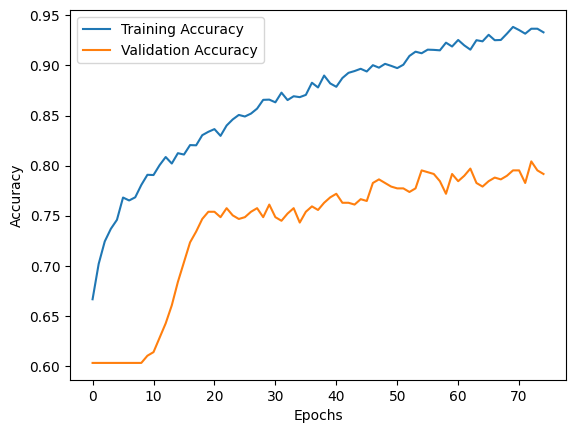

In [15]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

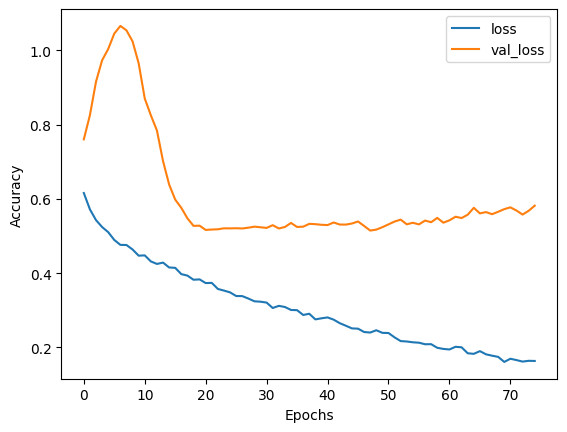

In [16]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


18/18 [==============================] - 1s 40ms/step


In [18]:
Y_test_original = label_encoder.inverse_transform(Y_test_encoded)
Y_pred_original = label_encoder.inverse_transform(y_pred_classes)

In [19]:
from sklearn.metrics import classification_report
report = classification_report(Y_test_original, Y_pred_original)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

    negative       0.82      0.87      0.84       344
    positive       0.77      0.69      0.73       213

    accuracy                           0.80       557
   macro avg       0.79      0.78      0.78       557
weighted avg       0.80      0.80      0.80       557



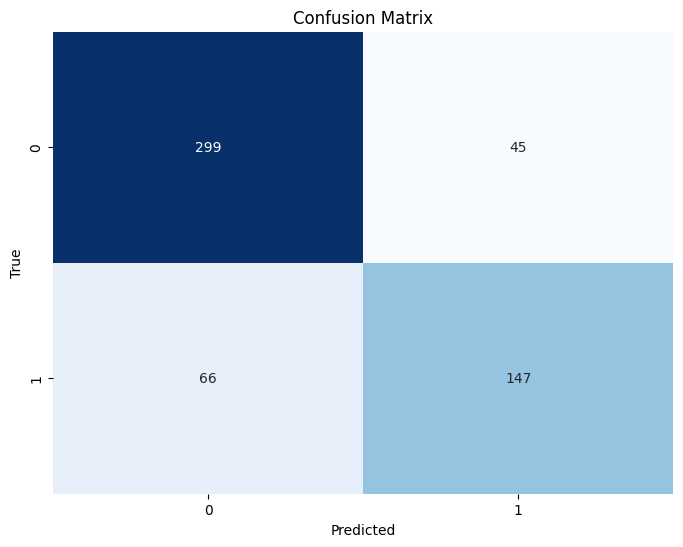

In [20]:
from sklearn.metrics import  confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

confusion = confusion_matrix(Y_test_original, Y_pred_original)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

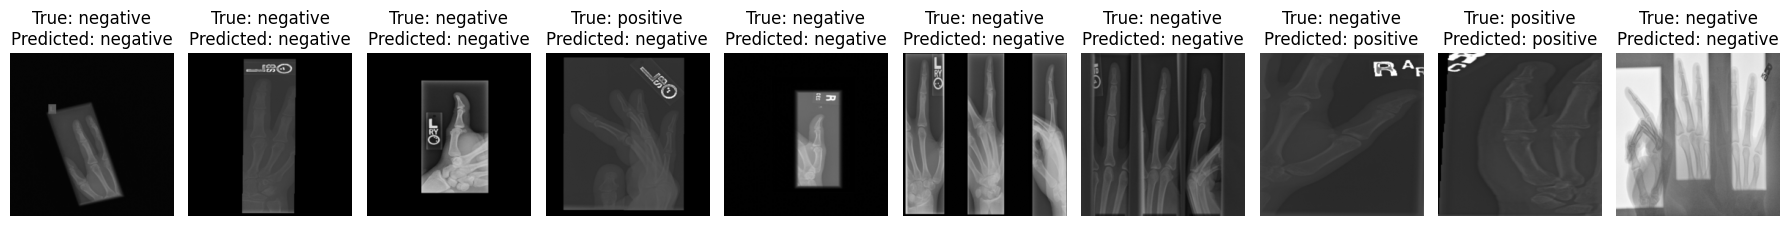

In [21]:
num_images_to_display = 10 
plt.figure(figsize=(18, 8))
for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(X_test[i])
    plt.title(f'True: {Y_test_original[i]}\nPredicted: {Y_pred_original[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [22]:
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2
import tensorflow as tf
def compute_gradcam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        class_idx = np.argmax(predictions[0])
        loss = predictions[:, class_idx]

    output = conv_output[0]
    grads = tape.gradient(loss, conv_output)[0]

    guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, output), axis=-1)
    
    cam = cv2.resize(cam.numpy(), (img_array.shape[1], img_array.shape[2]))
    cam = np.maximum(cam, 0)
    cam = (cam - cam.min()) / (cam.max() - cam.min())  

    return cam 

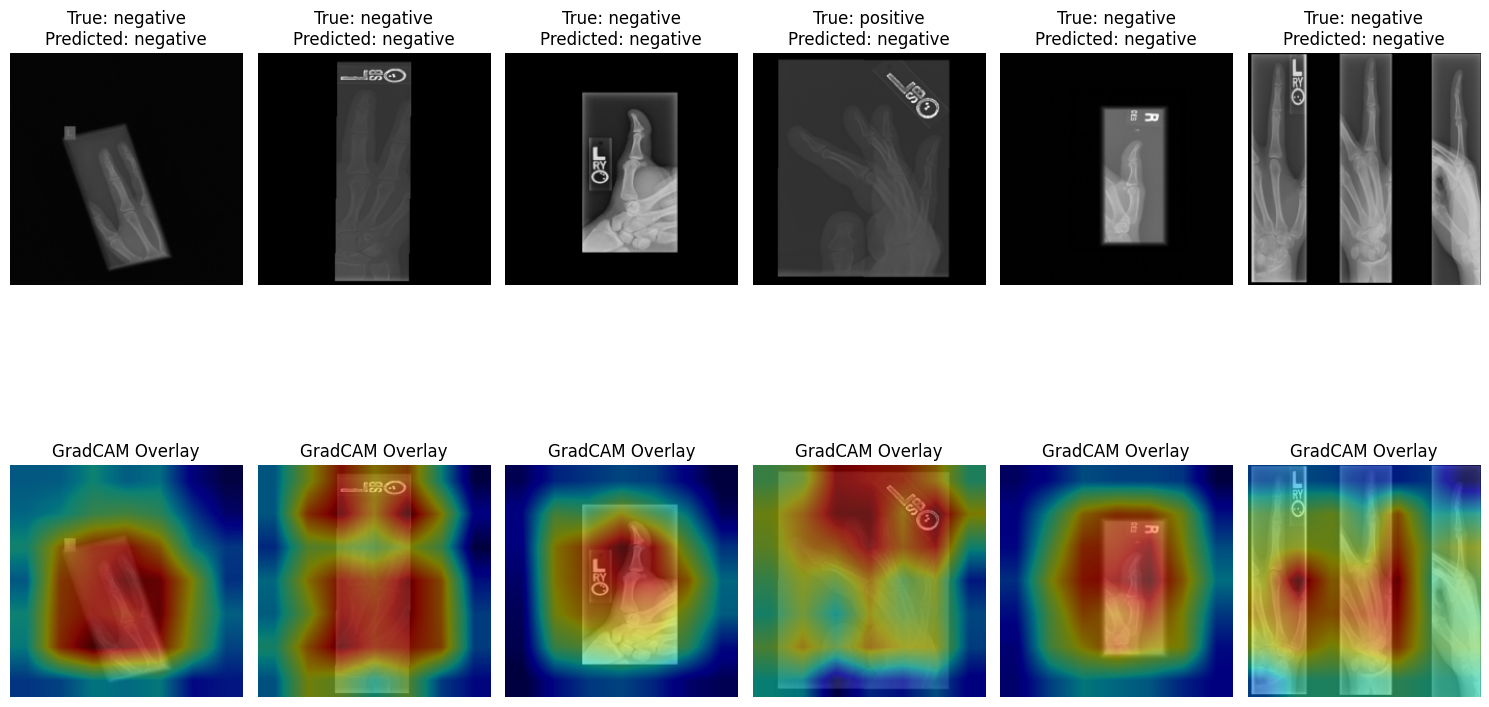

In [23]:
layer_name = 'Conv_1'
num_images_to_display = 6  

plt.figure(figsize=(15, 10))
for i in range(num_images_to_display):
    img = X_test[i]

    img = (img * 255).astype(np.uint8)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

    img_array = preprocess_input(np.expand_dims(img, axis=0))  
    cam = compute_gradcam(model, img_array, layer_name)

    cam = (cam - cam.min()) / (cam.max() - cam.min())

    plt.subplot(2, num_images_to_display, i + 1)
    plt.imshow(img, cmap='viridis') 
    plt.title(f'True: {Y_test_original[i]}\nPredicted: {Y_pred_original[i]}')
    plt.axis('off')

    plt.subplot(2, num_images_to_display, i + num_images_to_display + 1)
    plt.imshow(img, cmap='viridis')  
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.title('GradCAM Overlay')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [24]:
model_filename = "finger.h5"
model.save(model_filename)

print(f"Model saved as {model_filename}")

Model saved as finger.h5
